In [1]:
# import dependencies
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
# limit gpu 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


### Downloading Dataset

In [12]:
# download dataset & unpack

# url for dataset
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

train_dataset_dir = os.path.join(os.path.dirname(dataset), 'train')
test_dataset_dir = os.path.join(os.path.dirname(dataset), 'test')

In [13]:
# list the unpacked folder
print(os.listdir(train_dataset_dir))
print(os.listdir(test_dataset_dir))

['csharp', 'java', 'javascript', 'python']
['csharp', 'java', 'javascript', 'python']


In [15]:
# checking a file (comment of a video)
sample_file = os.path.join(train_dataset_dir, 'python/0.txt')
with open(sample_file) as f:
    print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

### Loading Dataset (Train / Validation / Test)

In [16]:
# preparing & loading train dataset into labelled tf.data.Dataset
# applying 0.2 validation split as dataset only provide training & test but not validation dataset
# obtain training subset here
# Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dataset_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dataset_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dataset_dir, 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [18]:
# print out few of the dataset to check
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print(text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public static void main

### PREPARE DATASET FOR TRAINING ###

Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the TextVectorization layer can be included directly inside your model, as shown later in this tutorial.

In [19]:
# custom standardization as default standardizer does not strip HTML
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [22]:
max_features = 10000
sequence_length = 250

# modified Vectorization layer (incl. standardizer, tokenizer & vectorizer)
vectorize_layer = layers.experimental.preprocessing.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',    # int to create unique int indices for each token
    output_sequence_length=sequence_length)

In [24]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)    # adapt the layer to training data

In [26]:
def vectorize_text(text, label):
    """grab text and return vectorized output"""
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [56]:
# test the layer & preview output 

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"what is an efficient way operating a set of variables? i am making a ""genetic simulator"", and at some point i want to compare the data in the genes to set the result in an individual. i came to a solution, but seems quite impractical, i\'m sure there is a proper way of doing it ..right now, i use a static method in a support class that handles the operation, but i fear that maintenance will be annoying, as i plan to modify the list of attributes quite often...public class geneops {  .    public static attributelist addattributelists (attributelist a, attributelist b) {.        attributelist x=new attributelist();..        x.agressiveness= a.agressiveness+b.agressiveness;.        x.bravery=a.bravery+b.bravery;.        x.speed=a.speed+b.speed;.        //repeat for all attributes..        return x;.    }.}...this works, but i would like something that is updated automatically every time i decide to add something to the list eg: if i add an attribute called sneak, i w

In [34]:
# getting vectorized vocabulary from index
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  saw
 313 --->  source
Vocabulary size: 10000


In [36]:
# process raw dataset to vectorized dataset
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [39]:
# tune dataset for performance
# AUTOTUNE = tf.data.AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### CREATE MODEL & TRAIN 

In [40]:
# create training MODEL
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [42]:
# compile model with desire loss func and optimizer
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [44]:
# train the model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7854 - accuracy: 0.7828 - val_loss: 0.7940 - val_accuracy: 0.7681
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7484 - accuracy: 0.7881 - val_loss: 0.7609 - val_accuracy: 0.7781
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7095 - accuracy: 0.8030 - val_loss: 0.7330 - val_accuracy: 0.7812
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.8122 - val_loss: 0.7062 - val_accuracy: 0.7900
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6445 - accuracy: 0.8188 - val_loss: 0.6837 - val_accuracy: 0.7944
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6195 - accuracy: 0.8291 - val_loss: 0.6630 - val_accuracy: 0.7950
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5942 - accuracy: 0.8323 - val_loss: 0.6445 - val_accuracy: 0.7969
Epoch 

### Evaluate 

In [45]:
# evaluate the trained model
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 13ms/step - loss: 0.6435 - accuracy: 0.7759
Loss:  0.6434732675552368
Accuracy:  0.7758749723434448


In [46]:
# vizualization using history return by model.fit
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

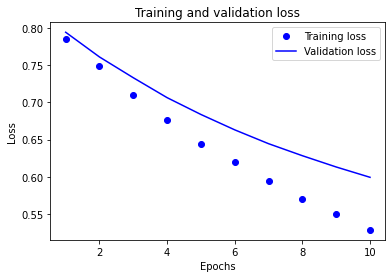

In [47]:
# plot loss graph
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

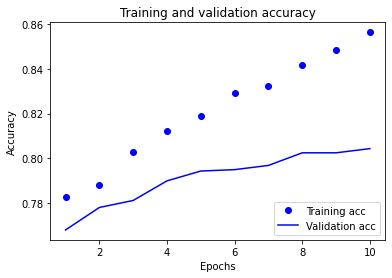

In [48]:
# plot accuracy graph
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Preparing Model to Export

In [54]:
# integrating preprocessing layer to model prior to exporting
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

# compile model to be exported
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 4s 15ms/step - loss: 0.6435 - accuracy: 0.7759
0.7758749723434448
